In [1]:
# ── Standard library ─────────────────────────────────────────────
import os
import random
import warnings
from datetime import datetime
from itertools import cycle

warnings.filterwarnings("ignore")

# ── Data handling ─────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ── Visualisation ─────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ── TensorFlow / Keras ────────────────────────────────────────────
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Transfer-learning backbones
from tensorflow.keras.applications.resnet50  import ResNet50,       preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16     import VGG16,          preprocess_input as vgg_preprocess
from tensorflow.keras.applications.densenet  import DenseNet121,    preprocess_input as dense_preprocess
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input as effnet_preprocess

# ── Sklearn metrics ───────────────────────────────────────────────
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2026-02-14 07:47:38.480525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771055258.648095     101 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771055258.700120     101 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771055259.107440     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771055259.107479     101 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771055259.107482     101 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ── Dataset path ─────────────────────────────────────────────────
# TrashNet dataset layout:
#   dataset-resized/
#       cardboard/ glass/ metal/ paper/ plastic/ trash/
BASE_PATH = "/kaggle/input/datasets/feyzazkefe/trashnet/dataset-resized" # ← update if your path differs

# ── Image / training settings ─────────────────────────────────────
IMG_SIZE      = (300, 300)
INPUT_SHAPE   = (300, 300, 3)
BATCH_SIZE    = 16
EPOCHS        = 10
NUM_CLASSES   = 6
VAL_SPLIT     = 0.2      # 80/20 train-val split
RANDOM_SEED   = 42

# ── Class names (alphabetical — matches Keras flow_from_directory) ─
CLASS_NAMES = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# ── Biodegradable mapping ─────────────────────────────────────────
BIODEGRADABLE_CLASSES     = {"cardboard", "paper", "trash"}
NON_BIODEGRADABLE_CLASSES = {"glass", "metal", "plastic"}
BINARY_CLASS_NAMES        = ["biodegradable", "non-biodegradable"]

# ── Output directories ─────────────────────────────────────────────
RESULTS_DIR            = "results"
MULTICLASS_RESULTS_DIR = os.path.join(RESULTS_DIR, "multiclass")
BINARY_RESULTS_DIR     = os.path.join(RESULTS_DIR, "binary")

for d in [MULTICLASS_RESULTS_DIR, BINARY_RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Output directories created:")
print(f"  {MULTICLASS_RESULTS_DIR}")
print(f"  {BINARY_RESULTS_DIR}")


Output directories created:
  results/multiclass
  results/binary


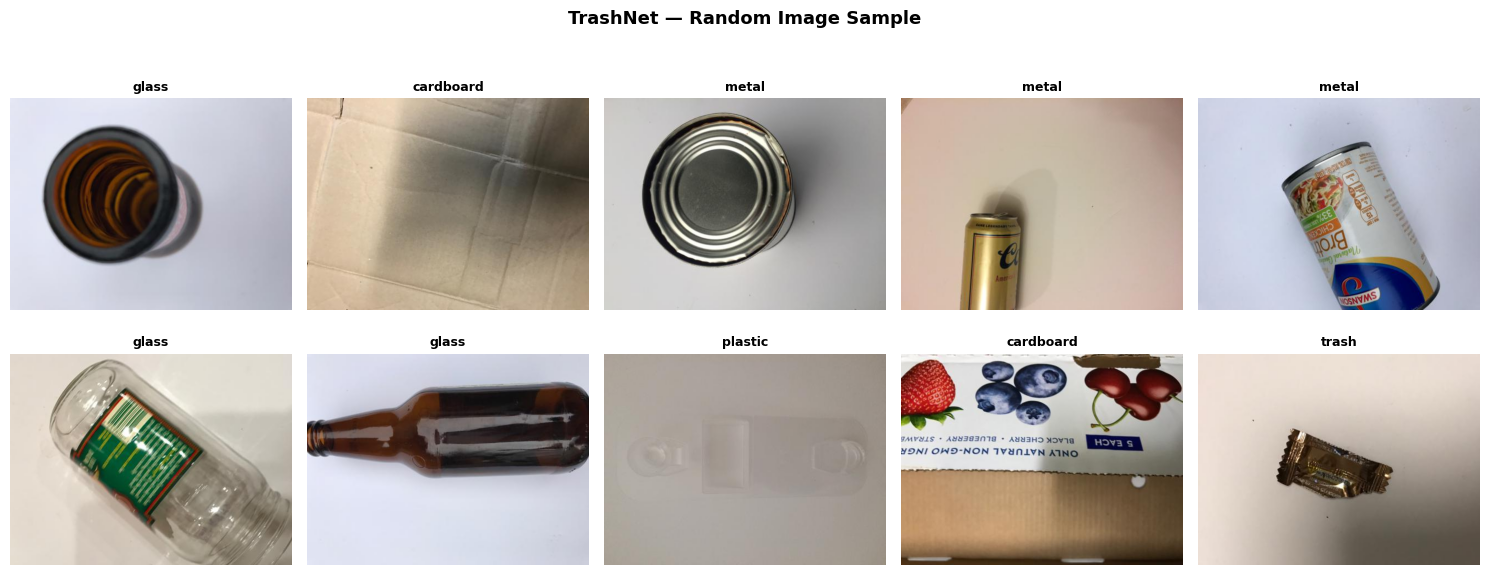

Saved: results/dataset_sample.png


In [3]:
def display_random_images(base_path, num_images=10, seed=RANDOM_SEED):
    """Display a random grid of images from the dataset with class labels."""
    all_images = []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_file in os.listdir(class_dir):
            if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                all_images.append((os.path.join(class_dir, img_file), class_name))

    random.seed(seed)
    sample = random.sample(all_images, min(num_images, len(all_images)))

    cols = min(5, num_images)
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).flatten()

    for ax, (img_path, label) in zip(axes, sample):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_title(label, fontsize=9, fontweight="bold")
        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.suptitle("TrashNet — Random Image Sample", fontsize=13, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "dataset_sample.png"), dpi=120, bbox_inches="tight")
    plt.show()
    print("Saved: results/dataset_sample.png")

display_random_images(BASE_PATH)


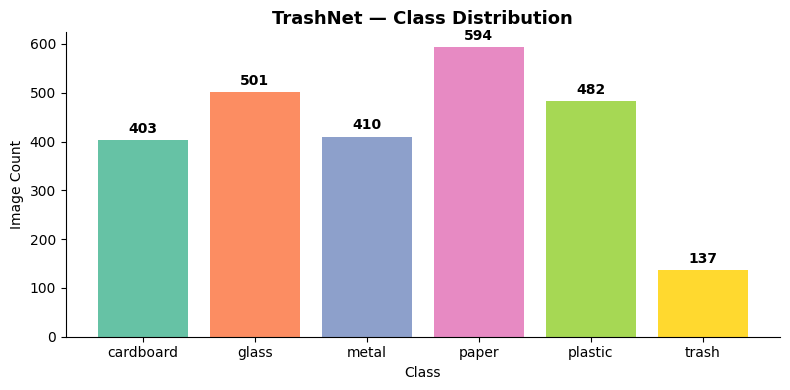

Total images: 2527


In [4]:
def plot_class_distribution(base_path):
    """Bar chart of per-class image counts."""
    counts = {}
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(base_path, class_name)
        if os.path.isdir(class_dir):
            counts[class_name] = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(counts.keys(), counts.values(),
                  color=sns.color_palette("Set2", len(counts)))
    ax.bar_label(bars, padding=3, fontweight="bold")
    ax.set_title("TrashNet — Class Distribution", fontsize=13, fontweight="bold")
    ax.set_xlabel("Class")
    ax.set_ylabel("Image Count")
    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "class_distribution.png"), dpi=120, bbox_inches="tight")
    plt.show()
    print(f"Total images: {sum(counts.values())}")
    return counts

class_counts = plot_class_distribution(BASE_PATH)


In [5]:
def load_dataset(base_path, preprocess_fn=None, img_size=IMG_SIZE,
                 batch_size=BATCH_SIZE, val_split=VAL_SPLIT,
                 seed=RANDOM_SEED, shuffle_test=False):
    """
    Create train, validation, and test generators for the given base path.

    Parameters
    ----------
    base_path    : str  – root directory with class sub-folders
    preprocess_fn: callable or None  – model-specific preprocessing function
                   (e.g. resnet_preprocess).  If None, rescale 1/255 is used.
    img_size     : tuple – (height, width)
    batch_size   : int
    val_split    : float – fraction kept for validation/test
    seed         : int   – random seed for reproducibility
    shuffle_test : bool  – whether test generator shuffles (keep False for eval)

    Returns
    -------
    train_generator, val_generator, test_generator
    """
    aug_kwargs = dict(
        shear_range=0.1,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=val_split,
        rotation_range=15,
        fill_mode="nearest",
    )
    basic_kwargs = dict(validation_split=val_split)

    if preprocess_fn:
        train_gen_cfg = {**aug_kwargs,  "preprocessing_function": preprocess_fn}
        val_gen_cfg   = {**basic_kwargs,"preprocessing_function": preprocess_fn}
    else:
        train_gen_cfg = {**aug_kwargs,  "rescale": 1.0 / 255}
        val_gen_cfg   = {**basic_kwargs,"rescale": 1.0 / 255}

    train_datagen = ImageDataGenerator(**train_gen_cfg)
    val_datagen   = ImageDataGenerator(**val_gen_cfg)
    test_datagen  = ImageDataGenerator(
        **({"preprocessing_function": preprocess_fn} if preprocess_fn
           else {"rescale": 1.0 / 255})
    )

    common = dict(
        directory=base_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        seed=seed,
    )

    train_generator = train_datagen.flow_from_directory(
        subset="training", shuffle=True, **common)
    val_generator   = val_datagen.flow_from_directory(
        subset="validation", shuffle=False, **common)
    test_generator  = test_datagen.flow_from_directory(
        shuffle=shuffle_test, **common)

    return train_generator, val_generator, test_generator

# ── Default generators (rescale only — used for CNN) ──────────────
train_gen, val_gen, test_gen = load_dataset(BASE_PATH)
print("Class indices:", train_gen.class_indices)
print(f"  Train samples : {train_gen.samples}")
print(f"  Val samples   : {val_gen.samples}")
print(f"  Test samples  : {test_gen.samples}")


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
  Train samples : 2024
  Val samples   : 503
  Test samples  : 2527


In [6]:
def build_simple_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES,
                     l2_val=0.001, dropout_rate=0.5):
    """Baseline CNN with L2 regularisation and dropout."""
    model = Sequential([
        Conv2D(32, (3,3), activation="relu", input_shape=input_shape,
               kernel_regularizer=l2(l2_val)),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(l2_val)),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation="relu", kernel_regularizer=l2(l2_val)),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=l2(l2_val)),
        Dropout(dropout_rate),
        Dense(num_classes, activation="softmax"),
    ], name="SimpleCNN")

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_cnn = build_simple_cnn()
model_cnn.summary()

I0000 00:00:1771055275.235165     101 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "SimpleCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    20,070,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,164,550 (76.92 MB)

 Trainable params: 20,164,550 (76.92 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
def build_transfer_model(base_model, num_classes=NUM_CLASSES,
                         dense_units=1024, dropout_rate=0.0,
                         l2_val=0.0, model_name="TransferModel"):
    """
    Generic transfer-learning wrapper.

    Freezes all backbone layers then adds:
        GlobalAveragePooling2D → Dense(dense_units, ReLU) → [optional Dropout]
        → Dense(num_classes, softmax)
    """
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu",
              kernel_regularizer=l2(l2_val) if l2_val > 0 else None)(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output, name=model_name)
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [8]:
resnet_base  = ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
model_resnet = build_transfer_model(resnet_base, model_name="ResNet50")
model_resnet.summary(line_length=100)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 300, 300, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_pad (ZeroPadding2D)   │ (None, 306, 306, 3)     │              0 │ input_layer_1[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_conv (Conv2D)         │ (None, 150, 150, 64)    │          9,472 │ conv1_pad[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_bn                    │ (None, 150, 150, 64)    │            256 │ conv1_conv[0][0]        │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_relu (Activation)     │ (None, 150, 150, 64)    │              0 │ conv1_bn[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pool1_pad (ZeroPadding2D)   │ (None, 152, 152, 64)    │              0 │ conv1_relu[0][0]        │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pool1_pool (MaxPooling2D)   │ (None, 75, 75, 64)      │              0 │ pool1_pad[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_conv         │ (None, 75, 75, 64)      │          4,160 │ pool1_pool[0][0]        │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_bn           │ (None, 75, 75, 64)      │            256 │ conv2_block1_1_conv[0]… │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_relu         │ (None, 75, 75, 64)      │              0 │ conv2_block1_1_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_conv         │ (None, 75, 75, 64)      │         36,928 │ conv2_block1_1_relu[0]… │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_bn           │ (None, 75, 75, 64)      │            256 │ conv2_block1_2_conv[0]… │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_relu         │ (None, 75, 75, 64)      │              0 │ conv2_block1_2_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_0_conv         │ (None, 75, 75, 256)     │         16,640 │ pool1_pool[0][0]        │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_3_conv         │ (None, 75, 75, 256)     │    

 Total params: 25,692,038 (98.01 MB)

 Trainable params: 2,104,326 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
vgg_base   = VGG16(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
model_vgg  = build_transfer_model(vgg_base, model_name="VGG16")
model_vgg.summary(line_length=100)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)                 │ (None, 300, 300, 3)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block1_conv1 (Conv2D)                      │ (None, 300, 300, 64)            │             1,792 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block1_conv2 (Conv2D)                      │ (None, 300, 300, 64)            │            36,928 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block1_pool (MaxPooling2D)                 │ (None, 150, 150, 64)            │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block2_conv1 (Conv2D)                      │ (None, 150, 150, 128)           │            73,856 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block2_conv2 (Conv2D)                      │ (None, 150, 150, 128)           │           147,584 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block2_pool (MaxPooling2D)                 │ (None, 75, 75, 128)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block3_conv1 (Conv2D)                      │ (None, 75, 75, 256)             │           295,168 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block3_conv2 (Conv2D)                      │ (None, 75, 75, 256)             │           590,080 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block3_conv3 (Conv2D)                      │ (None, 75, 75, 256)             │           590,080 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block3_pool (MaxPooling2D)                 │ (None, 37, 37, 256)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block4_conv1 (Conv2D)                      │ (None, 37, 37, 512)             │         1,180,160 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block4_conv2 (Conv2D)                      │ (None, 37, 37, 512)             │         2,359,808 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block4_conv3 (Conv2D)                      │ (None, 37, 37, 512)             │         2,359,808 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block4_pool (MaxPooling2D)                 │ (None, 18, 18, 512)             │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block5_conv1 (Conv2D)                      │ (None, 18, 18, 512)             │         2,359,808 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block5_conv2 (Conv2D)                      │ (None, 18, 18, 512)             │         2,359,808 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block5_conv3 (Conv2D)                      │ (None, 18, 18, 512)             │         2,359,808 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ block5_pool (MaxPooling2D)                 │ (None, 9, 9, 5

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
dense_base    = DenseNet121(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
model_densenet = build_transfer_model(dense_base, dense_units=1024,
                                      dropout_rate=0.5, l2_val=0.001,
                                      model_name="DenseNet121")
model_densenet.summary(line_length=100)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)  │ (None, 300, 300, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ zero_padding2d              │ (None, 306, 306, 3)     │              0 │ input_layer_3[0][0]     │
│ (ZeroPadding2D)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_conv (Conv2D)         │ (None, 150, 150, 64)    │          9,408 │ zero_padding2d[0][0]    │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_bn                    │ (None, 150, 150, 64)    │            256 │ conv1_conv[0][0]        │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv1_relu (Activation)     │ (None, 150, 150, 64)    │              0 │ conv1_bn[0][0]          │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ zero_padding2d_1            │ (None, 152, 152, 64)    │              0 │ conv1_relu[0][0]        │
│ (ZeroPadding2D)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ pool1 (MaxPooling2D)        │ (None, 75, 75, 64)      │              0 │ zero_padding2d_1[0][0]  │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_0_bn           │ (None, 75, 75, 64)      │            256 │ pool1[0][0]             │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_0_relu         │ (None, 75, 75, 64)      │              0 │ conv2_block1_0_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_conv         │ (None, 75, 75, 128)     │          8,192 │ conv2_block1_0_relu[0]… │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_bn           │ (None, 75, 75, 128)     │            512 │ conv2_block1_1_conv[0]… │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_1_relu         │ (None, 75, 75, 128)     │              0 │ conv2_block1_1_bn[0][0] │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_2_conv         │ (None, 75, 75, 32)      │         36,864 │ conv2_block1_1_relu[0]… │
│ (Conv2D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ conv2_block1_concat         │ (None, 75, 75, 96)      │              0 │ pool1[0][0],            │
│ (Concatenate)               │                         │    

 Total params: 8,093,254 (30.87 MB)

 Trainable params: 1,055,750 (4.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [11]:
effnet_base    = EfficientNetB0(weights="imagenet", include_top=False,
                                input_shape=INPUT_SHAPE)
model_effnet   = build_transfer_model(effnet_base, dense_units=512,
                                      dropout_rate=0.3,
                                      model_name="EfficientNetB0")
model_effnet.summary(line_length=100)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 300, 300, 3)     │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ rescaling (Rescaling)       │ (None, 300, 300, 3)     │              0 │ input_layer_4[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ normalization               │ (None, 300, 300, 3)     │              7 │ rescaling[0][0]         │
│ (Normalization)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ rescaling_1 (Rescaling)     │ (None, 300, 300, 3)     │              0 │ normalization[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_conv_pad               │ (None, 301, 301, 3)     │              0 │ rescaling_1[0][0]       │
│ (ZeroPadding2D)             │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_conv (Conv2D)          │ (None, 150, 150, 32)    │            864 │ stem_conv_pad[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_bn                     │ (None, 150, 150, 32)    │            128 │ stem_conv[0][0]         │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ stem_activation             │ (None, 150, 150, 32)    │              0 │ stem_bn[0][0]           │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_dwconv              │ (None, 150, 150, 32)    │            288 │ stem_activation[0][0]   │
│ (DepthwiseConv2D)           │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_bn                  │ (None, 150, 150, 32)    │            128 │ block1a_dwconv[0][0]    │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_activation          │ (None, 150, 150, 32)    │              0 │ block1a_bn[0][0]        │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_squeeze          │ (None, 32)              │              0 │ block1a_activation[0][… │
│ (GlobalAveragePooling2D)    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reshape          │ (None, 1, 1, 32)        │              0 │ block1a_se_squeeze[0][… │
│ (Reshape)                   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ block1a_se_reduce (Conv2D)  │ (None, 1, 1, 8)         │            264 │ block1a_se_reshape[0][… │
├─────────────────────────────┼─────────────────────────┼────

 Total params: 4,708,521 (17.96 MB)

 Trainable params: 658,950 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
def get_callbacks(patience_lr=3, patience_stop=7):
    """Standard callbacks shared across all models."""
    return [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                          patience=patience_lr, verbose=1),
        EarlyStopping(monitor="val_loss", patience=patience_stop,
                      restore_best_weights=True, verbose=1),
    ]

def train_model(model, train_generator, val_generator,
                epochs=EPOCHS, callbacks=None):
    """
    Fit a model and return its history.

    Parameters
    ----------
    model           : compiled Keras model
    train_generator : ImageDataGenerator flow
    val_generator   : ImageDataGenerator flow
    epochs          : int
    callbacks       : list of Keras callbacks (default: ReduceLR + EarlyStopping)

    Returns
    -------
    history : Keras History object
    """
    if callbacks is None:
        callbacks = get_callbacks()

    history = model.fit(
        train_generator,
        steps_per_epoch  = train_generator.samples  // train_generator.batch_size,
        epochs           = epochs,
        validation_data  = val_generator,
        validation_steps = val_generator.samples // val_generator.batch_size,
        callbacks        = callbacks,
    )
    return history

In [13]:
# CNN uses plain rescale generators (no backbone preprocessing)
train_gen_cnn, val_gen_cnn, test_gen_cnn = load_dataset(BASE_PATH)

print("Training Simple CNN …")
history_cnn = train_model(model_cnn, train_gen_cnn, val_gen_cnn)
model_cnn.save("models/cnn.h5")
print("Saved: models/cnn.h5")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Training Simple CNN …
Epoch 1/10


I0000 00:00:1771055287.199924     180 service.cc:152] XLA service 0x78d728004ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771055287.199959     180 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771055287.592039     180 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/126 ━━━━━━━━━━━━━━━━━━━━ 14:51 7s/step - accuracy: 0.2500 - loss: 2.1811

I0000 00:00:1771055292.289261     180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 407ms/step - accuracy: 0.2368 - loss: 2.3589 - val_accuracy: 0.3448 - val_loss: 1.7430 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5000 - loss: 1.5947 - val_accuracy: 0.3569 - val_loss: 1.7303 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.3408 - loss: 1.6603 - val_accuracy: 0.3649 - val_loss: 1.5942 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3125 - loss: 1.6477 - val_accuracy: 0.3589 - val_loss: 1.5992 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.4005 - loss: 1.5630 - val_accuracy: 0.3911 - val_loss: 1.6151 - learning_rate: 0.0010
Epoch 6/10
  1/126 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3125 - loss: 1.4710
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3125 - loss: 1.4710 -

Saved: models/cnn.h5


In [14]:
train_gen_resnet, val_gen_resnet, test_gen_resnet = load_dataset(
    BASE_PATH, preprocess_fn=resnet_preprocess)

print("Training ResNet50 …")
history_resnet = train_model(model_resnet, train_gen_resnet, val_gen_resnet)
model_resnet.save("models/resnet50.h5")
print("Saved: models/resnet50.h5")


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Training ResNet50 …
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 349ms/step - accuracy: 0.6650 - loss: 1.0650 - val_accuracy: 0.8065 - val_loss: 0.5251 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8125 - loss: 0.4965 - val_accuracy: 0.8004 - val_loss: 0.5299 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - accuracy: 0.8695 - loss: 0.3538 - val_accuracy: 0.8185 - val_loss: 0.4615 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9375 - loss: 0.2438 - val_accuracy: 0.8065 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 301ms/step - accuracy: 0.8998 - loss: 0.2646 - val_accuracy: 0.7964 - val_loss: 0.6032 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 1.0000 - loss: 0.06

Saved: models/resnet50.h5


In [15]:
train_gen_vgg, val_gen_vgg, test_gen_vgg = load_dataset(
    BASE_PATH, preprocess_fn=vgg_preprocess)

print("Training VGG-16 …")
history_vgg = train_model(model_vgg, train_gen_vgg, val_gen_vgg)
model_vgg.save("models/vgg16.h5")
print("Saved: models/vgg16.h5")


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Training VGG-16 …
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step - accuracy: 0.6591 - loss: 1.4012 - val_accuracy: 0.7460 - val_loss: 0.7021 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8125 - loss: 0.2590 - val_accuracy: 0.7218 - val_loss: 0.7592 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 307ms/step - accuracy: 0.8693 - loss: 0.3743 - val_accuracy: 0.7984 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8750 - loss: 0.2547 - val_accuracy: 0.7964 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - accuracy: 0.8846 - loss: 0.3027 - val_accuracy: 0.7802 - val_loss: 0.6377 - learning_rate: 0.0010
Epoch 6/10
  1/126 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - accuracy: 0.8750 - loss: 0.3730

Saved: models/vgg16.h5


In [16]:
train_gen_dense, val_gen_dense, test_gen_dense = load_dataset(
    BASE_PATH, preprocess_fn=dense_preprocess)

print("Training DenseNet121 …")
history_densenet = train_model(model_densenet, train_gen_dense, val_gen_dense)
model_densenet.save("models/densenet121.h5")
print("Saved: models/densenet121.h5")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Training DenseNet121 …
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 87s 492ms/step - accuracy: 0.5921 - loss: 1.8426 - val_accuracy: 0.8427 - val_loss: 0.9303 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6875 - loss: 1.2030 - val_accuracy: 0.8468 - val_loss: 0.9255 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.8265 - loss: 0.9227 - val_accuracy: 0.8367 - val_loss: 0.8266 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8125 - loss: 0.8616 - val_accuracy: 0.8407 - val_loss: 0.8274 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 294ms/step - accuracy: 0.8270 - loss: 0.8264 - val_accuracy: 0.8750 - val_loss: 0.7354 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9375 - loss: 0

Saved: models/densenet121.h5


In [17]:
train_gen_effnet, val_gen_effnet, test_gen_effnet = load_dataset(
    BASE_PATH, preprocess_fn=effnet_preprocess)

print("Training EfficientNetB0 …")
history_effnet = train_model(model_effnet, train_gen_effnet, val_gen_effnet)
model_effnet.save("models/efficientnetb0.h5")
print("Saved: models/efficientnetb0.h5")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Training EfficientNetB0 …
Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 76s 428ms/step - accuracy: 0.7155 - loss: 0.7787 - val_accuracy: 0.8145 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8750 - loss: 0.5191 - val_accuracy: 0.8185 - val_loss: 0.4879 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.8924 - loss: 0.3044 - val_accuracy: 0.8649 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8125 - loss: 0.4407 - val_accuracy: 0.8649 - val_loss: 0.4145 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 282ms/step - accuracy: 0.9285 - loss: 0.2321 - val_accuracy: 0.8649 - val_loss: 0.3646 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss

Saved: models/efficientnetb0.h5


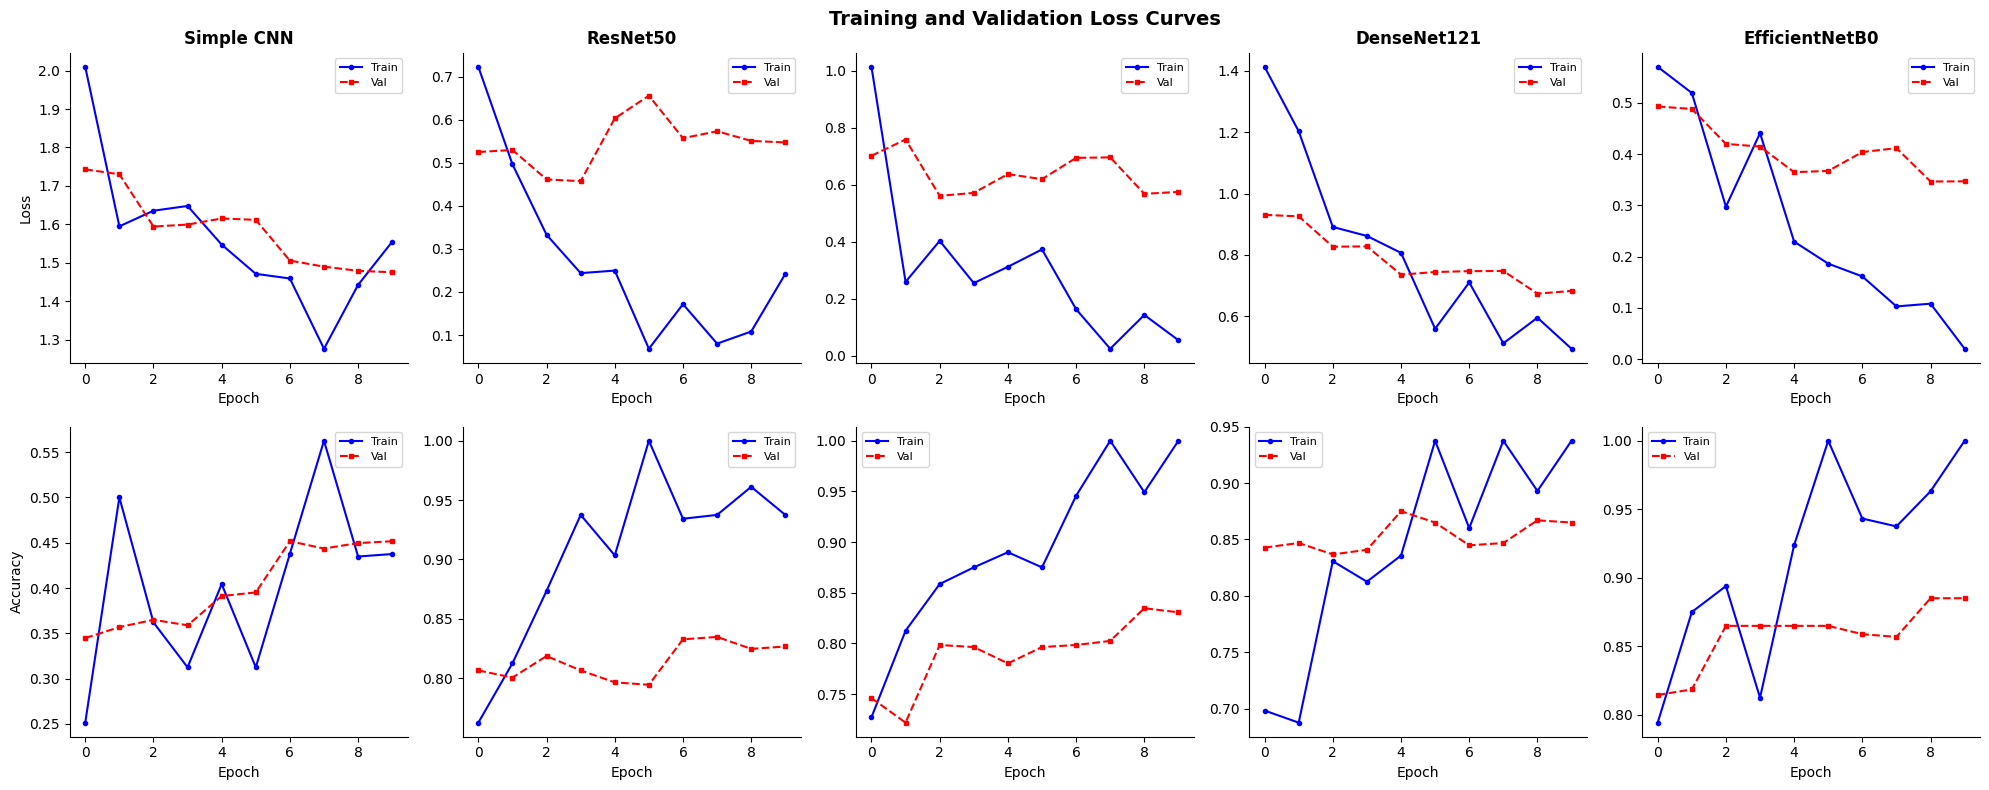

Saved: results/multiclass/training_curves_all_models.png


In [18]:
def plot_training_curves(histories, names, save_dir=MULTICLASS_RESULTS_DIR):
    """Side-by-side loss and accuracy curves for all models."""
    n = len(histories)
    fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))

    for idx, (h, name) in enumerate(zip(histories, names)):
        # Loss
        ax_loss = axes[0, idx]
        ax_loss.plot(h.history["loss"],     "b-o",  ms=3, label="Train")
        ax_loss.plot(h.history["val_loss"], "r--s", ms=3, label="Val")
        ax_loss.set_title(f"{name}", fontweight="bold")
        ax_loss.set_xlabel("Epoch")
        if idx == 0:
            ax_loss.set_ylabel("Loss")
        ax_loss.legend(fontsize=8)
        sns.despine(ax=ax_loss)

        # Accuracy
        ax_acc = axes[1, idx]
        ax_acc.plot(h.history["accuracy"],     "b-o",  ms=3, label="Train")
        ax_acc.plot(h.history["val_accuracy"], "r--s", ms=3, label="Val")
        ax_acc.set_xlabel("Epoch")
        if idx == 0:
            ax_acc.set_ylabel("Accuracy")
        ax_acc.legend(fontsize=8)
        sns.despine(ax=ax_acc)

    axes[0, n // 2].set_title("Training and Validation Loss Curves",
                               fontsize=14, fontweight="bold", pad=20)
    plt.tight_layout()
    path = os.path.join(save_dir, "training_curves_all_models.png")
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")

all_histories = [history_cnn, history_resnet, history_vgg,
                 history_densenet, history_effnet]
all_names     = ["Simple CNN", "ResNet50", "VGG-16",
                 "DenseNet121", "EfficientNetB0"]

plot_training_curves(all_histories, all_names)


In [19]:
def predict_with_model(model, generator):
    """
    Run inference on a generator and return raw probability matrix.

    Parameters
    ----------
    model     : trained Keras model
    generator : ImageDataGenerator flow (shuffle=False for evaluation)

    Returns
    -------
    probs : np.ndarray of shape (n_samples, n_classes)  – softmax probabilities
    """
    generator.reset()
    steps = int(np.ceil(generator.samples / generator.batch_size))
    probs = model.predict(generator, steps=steps, verbose=1)
    return probs

In [20]:
def evaluate_model(y_true, y_pred_probs, class_names,
                   model_name="Model", save_dir=MULTICLASS_RESULTS_DIR):
    """
    Full evaluation suite for one model.

    Prints classification report; returns dict with scalar metrics.
    Also saves all plots to save_dir.

    Parameters
    ----------
    y_true       : 1-D int array of true class indices
    y_pred_probs : 2-D float array (n_samples × n_classes) — softmax probs
    class_names  : list of str — display names for classes
    model_name   : str — used for titles and file names
    save_dir     : str — output folder

    Returns
    -------
    metrics : dict with keys accuracy, precision, recall, f1, per-class f1
    """
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc   = np.mean(y_pred == y_true)
    prec  = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec   = recall_score   (y_true, y_pred, average="weighted", zero_division=0)
    f1    = f1_score       (y_true, y_pred, average="weighted", zero_division=0)
    f1_pc = f1_score       (y_true, y_pred, average=None,       zero_division=0)

    print(f"\n{'='*60}")
    print(f"  {model_name} — Evaluation Report")
    print(f"{'='*60}")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {prec:.4f}  (weighted)")
    print(f"  Recall    : {rec:.4f}  (weighted)")
    print(f"  F1 Score  : {f1:.4f}  (weighted)")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=class_names, zero_division=0))

    plot_confusion_matrix(y_true, y_pred, class_names,
                          model_name, save_dir)
    plot_roc_curve(y_true, y_pred_probs, class_names,
                   model_name, save_dir)

    return {
        "model": model_name,
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1,
        "f1_per_class": f1_pc.tolist(),
    }


In [22]:
def plot_confusion_matrix(y_true, y_pred, class_names,
                          model_name="Model", save_dir=MULTICLASS_RESULTS_DIR):
    """
    Professional seaborn heatmap confusion matrix.

    Normalises by true count so each cell shows recall per class.
    Also annotates raw counts.
    """
    cm      = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(
        cm_norm, annot=cm, fmt="d",
        cmap="Blues", linewidths=0.5, linecolor="white",
        xticklabels=class_names, yticklabels=class_names,
        ax=ax, vmin=0, vmax=1,
        cbar_kws={"label": "Recall (row-normalised)"},
    )
    ax.set_xlabel("Predicted Class", fontweight="bold")
    ax.set_ylabel("True Class",      fontweight="bold")
    ax.set_title(f"{model_name} — Confusion Matrix", fontsize=12, fontweight="bold")
    plt.xticks(rotation=35, ha="right", fontsize=9)
    plt.yticks(rotation=0,  fontsize=9)
    plt.tight_layout()

    safe_name = model_name.replace(" ", "_").replace("/", "-")
    path = os.path.join(save_dir, f"confusion_matrix_{safe_name}.png")
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")


In [23]:
def plot_roc_curve(y_true, y_pred_probs, class_names,
                   model_name="Model", save_dir=MULTICLASS_RESULTS_DIR):
    """
    One-vs-rest multi-class ROC curves + micro/macro averages.
    """
    n_classes = len(class_names)
    y_bin     = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])
        roc_auc[i]        = auc(fpr[i], tpr[i])

    # Micro average
    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_bin.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    palette = sns.color_palette("tab10", n_classes)
    fig, ax  = plt.subplots(figsize=(7, 6))
    colors   = cycle(palette)

    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], lw=1.5, color=color,
                label=f"{class_names[i]}  (AUC = {roc_auc[i]:.2f})")

    ax.plot(fpr["micro"], tpr["micro"],
            lw=2.5, linestyle=":", color="deeppink",
            label=f"Micro-avg  (AUC = {roc_auc['micro']:.2f})")
    ax.plot(fpr["macro"], tpr["macro"],
            lw=2.5, linestyle="--", color="navy",
            label=f"Macro-avg  (AUC = {roc_auc['macro']:.2f})")

    ax.plot([0,1],[0,1], "k--", lw=1, alpha=0.5)
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1.02])
    ax.set_xlabel("False Positive Rate", fontweight="bold")
    ax.set_ylabel("True Positive Rate",  fontweight="bold")
    ax.set_title(f"{model_name} — ROC Curves (OvR)", fontsize=12, fontweight="bold")
    ax.legend(loc="lower right", fontsize=8)
    sns.despine(ax=ax)
    plt.tight_layout()

    safe_name = model_name.replace(" ", "_").replace("/", "-")
    path = os.path.join(save_dir, f"roc_curve_{safe_name}.png")
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")


In [24]:
def plot_accuracy_comparison(metrics_list, save_dir=MULTICLASS_RESULTS_DIR,
                             suffix=""):
    """
    Grouped bar chart comparing accuracy, precision, recall, F1
    across all models (individual + ensemble).
    """
    df = pd.DataFrame(metrics_list)[
        ["model", "accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]
    ].set_index("model")
    df.columns = ["Accuracy", "Precision", "Recall", "F1"]

    ax = df.plot(kind="bar", figsize=(11, 5), colormap="Set2",
                 edgecolor="black", linewidth=0.6)
    ax.set_title("Model Performance Comparison", fontsize=13, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Score")
    ax.set_ylim(0, 1.08)
    plt.xticks(rotation=25, ha="right")

    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", fontsize=7, padding=2)

    ax.legend(loc="lower right", fontsize=9)
    sns.despine(ax=ax)
    plt.tight_layout()

    path = os.path.join(save_dir, f"accuracy_comparison{suffix}.png")
    plt.savefig(path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")

In [25]:
def weighted_vote(predictions, weights):
    """
    Compute a weighted-average ensemble of model probability outputs.

    Parameters
    ----------
    predictions : list of np.ndarray, each shape (n_samples, n_classes)
                  Softmax probability matrices from each model.
    weights     : list of float — one scalar weight per model.
                  Weights are automatically normalised to sum to 1.

    Returns
    -------
    ensemble_probs : np.ndarray, shape (n_samples, n_classes)
                     Weighted-average probability distribution.
    """
    assert len(predictions) == len(weights),         "Number of predictions must equal number of weights."
    assert len(predictions) > 0, "At least one set of predictions required."

    weights_arr    = np.array(weights, dtype=float)
    weights_arr   /= weights_arr.sum()          # normalise

    ensemble_probs = np.zeros_like(predictions[0], dtype=float)
    for probs, w in zip(predictions, weights_arr):
        ensemble_probs += w * probs

    return ensemble_probs

In [26]:
# ── Extract final validation accuracy from training histories ──────
def extract_val_accuracy(history):
    """Return best validation accuracy achieved during training."""
    return max(history.history["val_accuracy"])

val_accuracies = {
    "Simple CNN"    : extract_val_accuracy(history_cnn),
    "ResNet50"      : extract_val_accuracy(history_resnet),
    "VGG-16"        : extract_val_accuracy(history_vgg),
    "DenseNet121"   : extract_val_accuracy(history_densenet),
    "EfficientNetB0": extract_val_accuracy(history_effnet),
}

print("Validation accuracies used as ensemble weights:")
for name, acc in val_accuracies.items():
    print(f"  {name:<20} {acc:.4f}")

Validation accuracies used as ensemble weights:
  Simple CNN           0.4516
  ResNet50             0.8347
  VGG-16               0.8347
  DenseNet121          0.8750
  EfficientNetB0       0.8851


In [27]:
# ── Each model uses its own test generator (correct preprocessing) ─
print("Generating predictions for all models on test set …\n")

probs_cnn     = predict_with_model(model_cnn,     test_gen_cnn)
probs_resnet  = predict_with_model(model_resnet,  test_gen_resnet)
probs_vgg     = predict_with_model(model_vgg,     test_gen_vgg)
probs_densenet= predict_with_model(model_densenet,test_gen_dense)
probs_effnet  = predict_with_model(model_effnet,  test_gen_effnet)

# Ground truth — use any shuffled=False generator (labels identical)
y_true_mc = test_gen_cnn.classes
print(f"Test samples: {len(y_true_mc)}")

Generating predictions for all models on test set …

158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

2026-02-14 08:09:10.892955: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 08:09:11.132780: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 08:09:12.167649: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 08:09:12.431263: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

2026-02-14 08:09:40.047416: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-14 08:09:40.287331: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step
Test samples: 2527



  Simple CNN — Evaluation Report
  Accuracy  : 0.4899
  Precision : 0.4880  (weighted)
  Recall    : 0.4899  (weighted)
  F1 Score  : 0.4713  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.83      0.75      0.78       403
       glass       0.51      0.27      0.35       501
       metal       0.36      0.38      0.37       410
       paper       0.52      0.49      0.51       594
     plastic       0.39      0.73      0.51       482
       trash       0.00      0.00      0.00       137

    accuracy                           0.49      2527
   macro avg       0.43      0.44      0.42      2527
weighted avg       0.49      0.49      0.47      2527



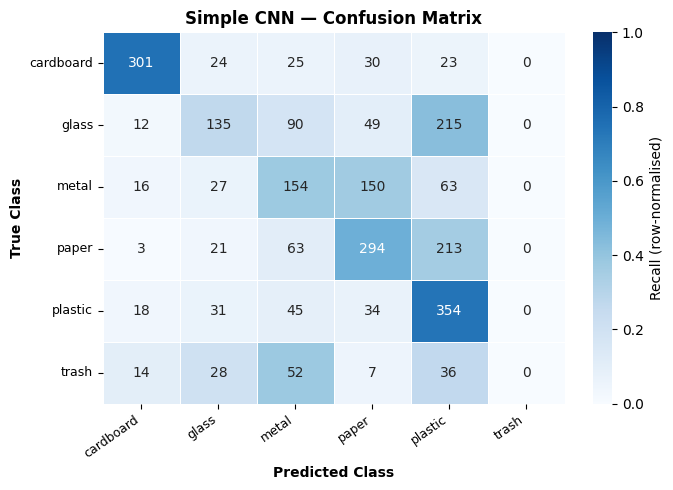

Saved: results/multiclass/confusion_matrix_Simple_CNN.png


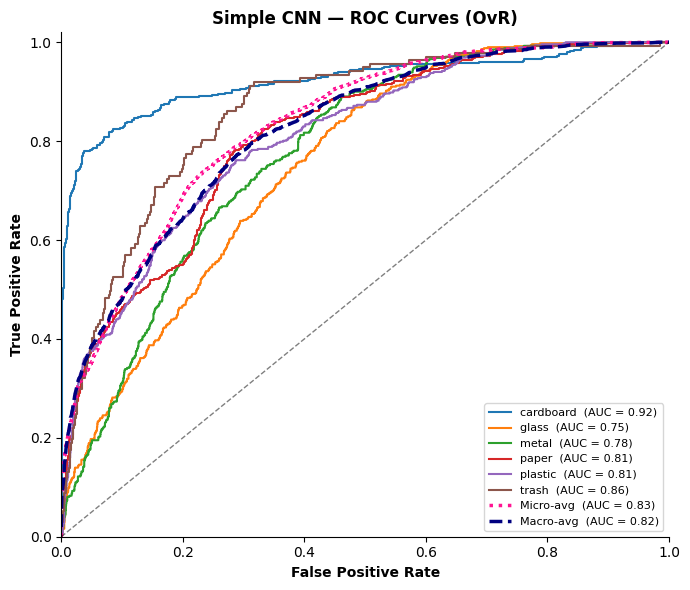

Saved: results/multiclass/roc_curve_Simple_CNN.png

  ResNet50 — Evaluation Report
  Accuracy  : 0.9050
  Precision : 0.9088  (weighted)
  Recall    : 0.9050  (weighted)
  F1 Score  : 0.9047  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.94      0.95       403
       glass       0.86      0.95      0.90       501
       metal       0.95      0.84      0.89       410
       paper       0.94      0.93      0.94       594
     plastic       0.83      0.92      0.87       482
       trash       0.91      0.69      0.78       137

    accuracy                           0.91      2527
   macro avg       0.91      0.88      0.89      2527
weighted avg       0.91      0.91      0.90      2527



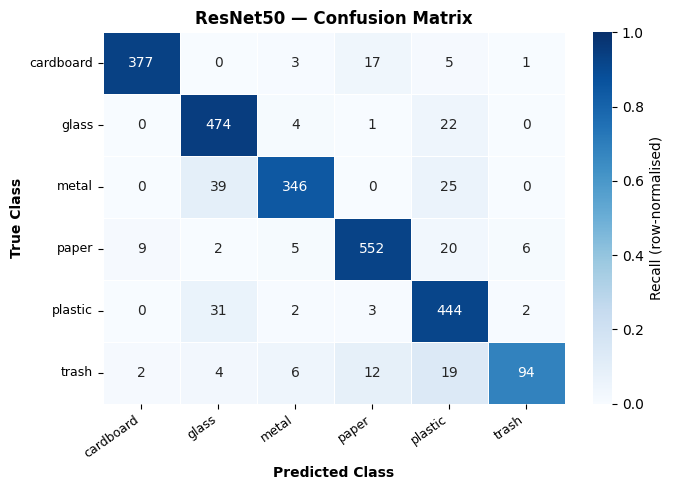

Saved: results/multiclass/confusion_matrix_ResNet50.png


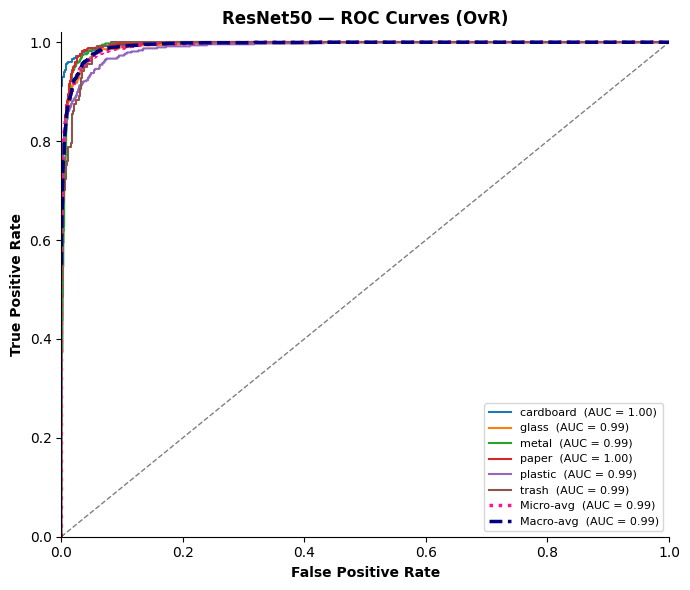

Saved: results/multiclass/roc_curve_ResNet50.png

  VGG-16 — Evaluation Report
  Accuracy  : 0.8880
  Precision : 0.8895  (weighted)
  Recall    : 0.8880  (weighted)
  F1 Score  : 0.8877  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.85      0.98      0.91       403
       glass       0.91      0.86      0.88       501
       metal       0.89      0.92      0.91       410
       paper       0.93      0.89      0.91       594
     plastic       0.88      0.86      0.87       482
       trash       0.78      0.75      0.77       137

    accuracy                           0.89      2527
   macro avg       0.87      0.88      0.87      2527
weighted avg       0.89      0.89      0.89      2527



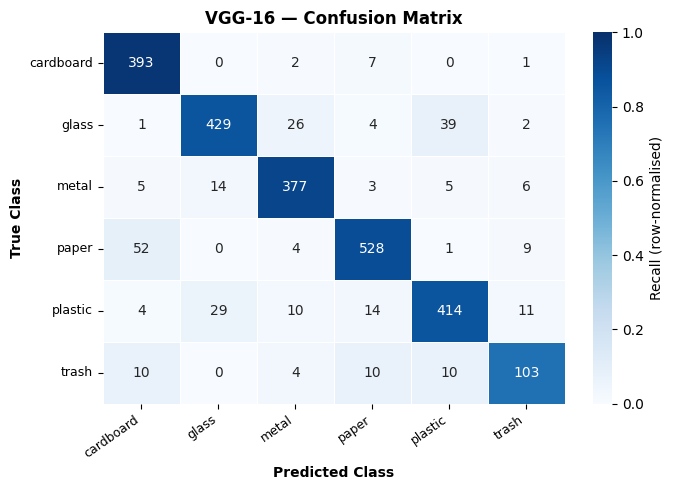

Saved: results/multiclass/confusion_matrix_VGG-16.png


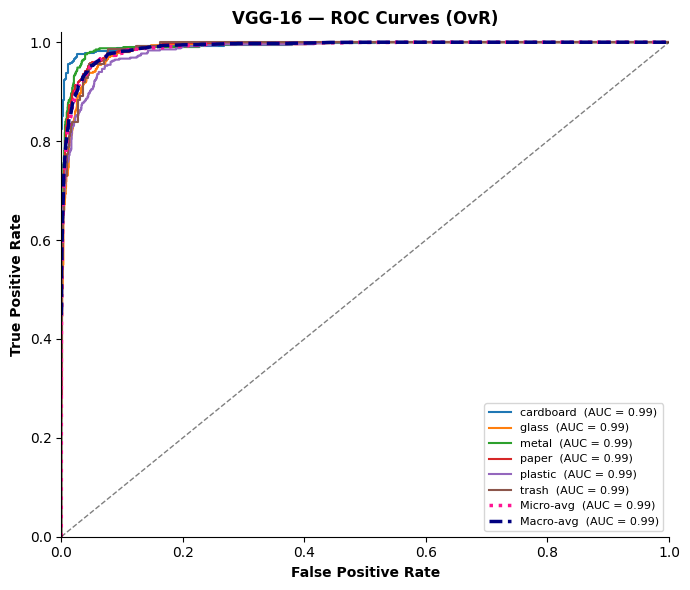

Saved: results/multiclass/roc_curve_VGG-16.png

  DenseNet121 — Evaluation Report
  Accuracy  : 0.9264
  Precision : 0.9292  (weighted)
  Recall    : 0.9264  (weighted)
  F1 Score  : 0.9265  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.94      0.95       403
       glass       0.90      0.95      0.92       501
       metal       0.90      0.94      0.92       410
       paper       0.95      0.95      0.95       594
     plastic       0.97      0.85      0.90       482
       trash       0.81      0.93      0.86       137

    accuracy                           0.93      2527
   macro avg       0.91      0.93      0.92      2527
weighted avg       0.93      0.93      0.93      2527



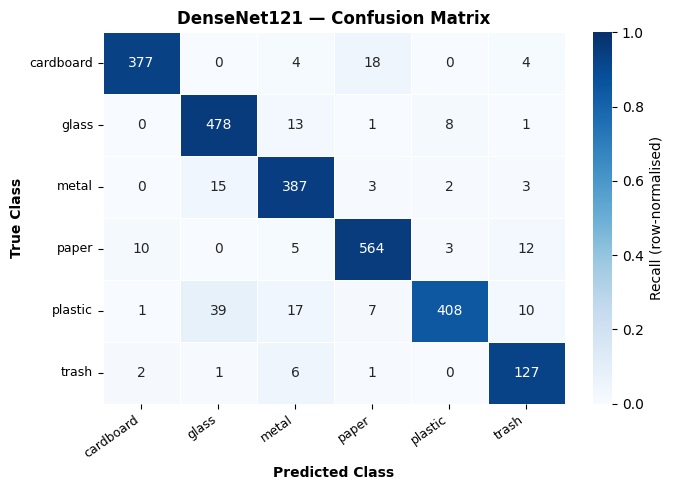

Saved: results/multiclass/confusion_matrix_DenseNet121.png


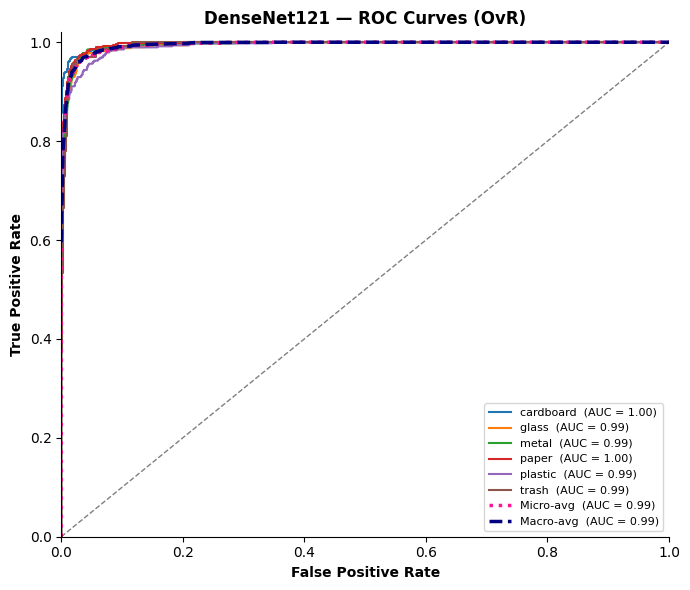

Saved: results/multiclass/roc_curve_DenseNet121.png

  EfficientNetB0 — Evaluation Report
  Accuracy  : 0.9691
  Precision : 0.9694  (weighted)
  Recall    : 0.9691  (weighted)
  F1 Score  : 0.9691  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.97      0.98       403
       glass       0.96      0.97      0.96       501
       metal       0.95      0.97      0.96       410
       paper       0.97      0.99      0.98       594
     plastic       0.98      0.95      0.97       482
       trash       0.95      0.93      0.94       137

    accuracy                           0.97      2527
   macro avg       0.97      0.96      0.97      2527
weighted avg       0.97      0.97      0.97      2527



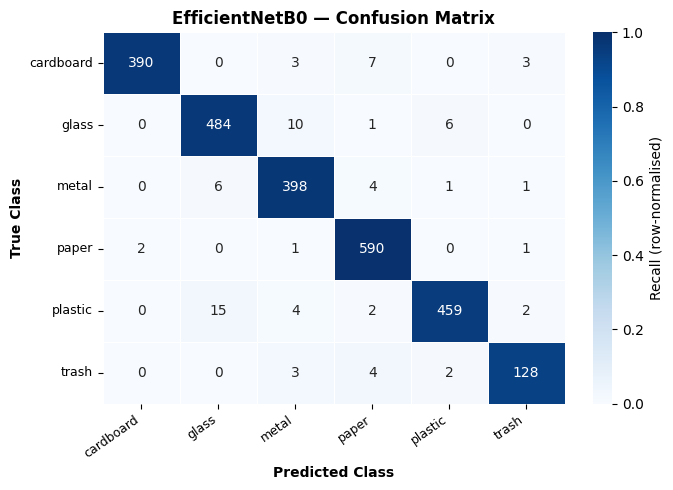

Saved: results/multiclass/confusion_matrix_EfficientNetB0.png


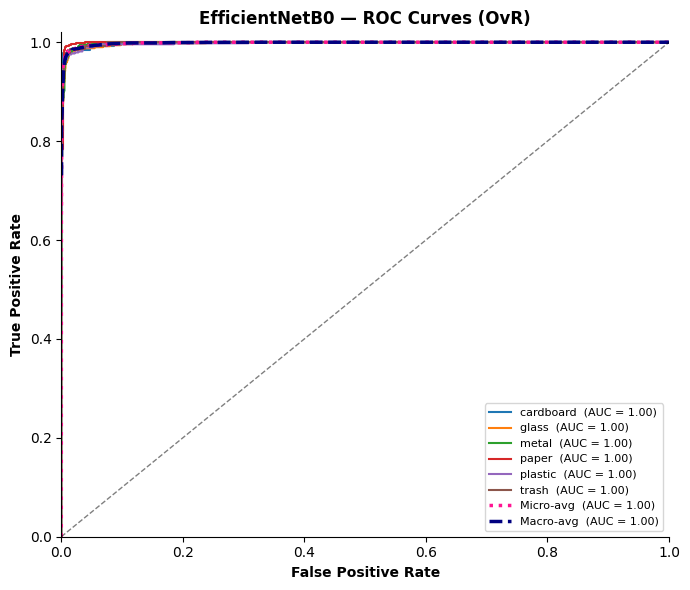

Saved: results/multiclass/roc_curve_EfficientNetB0.png


In [28]:
# ── Evaluate individual models ─────────────────────────────────────
mc_metrics = []

for name, probs in [
    ("Simple CNN",     probs_cnn),
    ("ResNet50",       probs_resnet),
    ("VGG-16",         probs_vgg),
    ("DenseNet121",    probs_densenet),
    ("EfficientNetB0", probs_effnet),
]:
    m = evaluate_model(y_true_mc, probs, CLASS_NAMES,
                       model_name=name, save_dir=MULTICLASS_RESULTS_DIR)
    mc_metrics.append(m)


  Weighted Ensemble — Evaluation Report
  Accuracy  : 0.9624
  Precision : 0.9625  (weighted)
  Recall    : 0.9624  (weighted)
  F1 Score  : 0.9623  (weighted)

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.99      0.97      0.98       403
       glass       0.95      0.97      0.96       501
       metal       0.95      0.97      0.96       410
       paper       0.97      0.98      0.98       594
     plastic       0.97      0.94      0.96       482
       trash       0.94      0.86      0.90       137

    accuracy                           0.96      2527
   macro avg       0.96      0.95      0.95      2527
weighted avg       0.96      0.96      0.96      2527



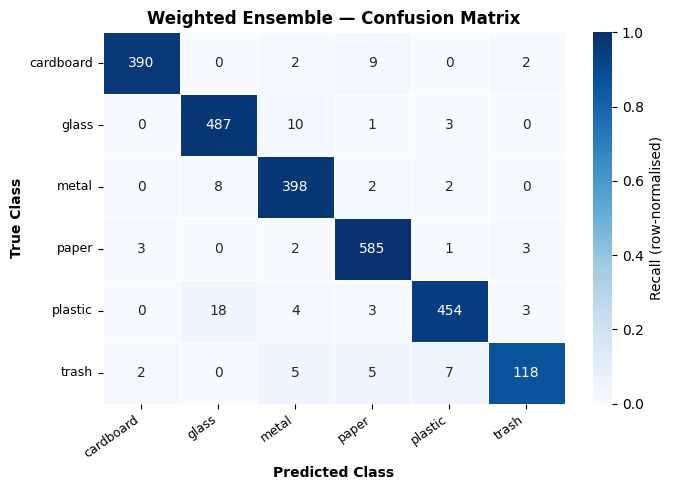

Saved: results/multiclass/confusion_matrix_Weighted_Ensemble.png


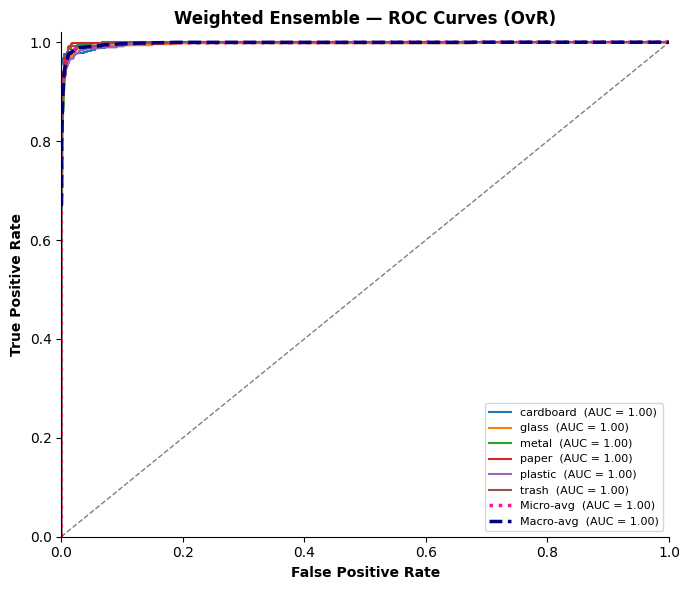

Saved: results/multiclass/roc_curve_Weighted_Ensemble.png


In [29]:
# ── Weighted ensemble on multiclass task ──────────────────────────
mc_weights = [
    val_accuracies["Simple CNN"],
    val_accuracies["ResNet50"],
    val_accuracies["VGG-16"],
    val_accuracies["DenseNet121"],
    val_accuracies["EfficientNetB0"],
]

ensemble_probs_mc = weighted_vote(
    [probs_cnn, probs_resnet, probs_vgg, probs_densenet, probs_effnet],
    mc_weights
)

m_ens = evaluate_model(y_true_mc, ensemble_probs_mc, CLASS_NAMES,
                        model_name="Weighted Ensemble",
                        save_dir=MULTICLASS_RESULTS_DIR)
mc_metrics.append(m_ens)

In [30]:
# ── Summary table ─────────────────────────────────────────────────
mc_summary = pd.DataFrame([
    {
        "Model"    : m["model"],
        "Accuracy" : round(m["accuracy"], 4),
        "Precision": round(m["precision_weighted"], 4),
        "Recall"   : round(m["recall_weighted"], 4),
        "F1"       : round(m["f1_weighted"], 4),
    }
    for m in mc_metrics
])
mc_summary = mc_summary.sort_values("F1", ascending=False).reset_index(drop=True)
print("\n── Multiclass Performance Summary ──────────────────────────")
print(mc_summary.to_string(index=False))

mc_summary.to_csv(
    os.path.join(MULTICLASS_RESULTS_DIR, "performance_summary.csv"), index=False)
print("\nSaved: results/multiclass/performance_summary.csv")


── Multiclass Performance Summary ──────────────────────────
            Model  Accuracy  Precision  Recall     F1
   EfficientNetB0    0.9691     0.9694  0.9691 0.9691
Weighted Ensemble    0.9624     0.9625  0.9624 0.9623
      DenseNet121    0.9264     0.9292  0.9264 0.9265
         ResNet50    0.9050     0.9088  0.9050 0.9047
           VGG-16    0.8880     0.8895  0.8880 0.8877
       Simple CNN    0.4899     0.4880  0.4899 0.4713

Saved: results/multiclass/performance_summary.csv


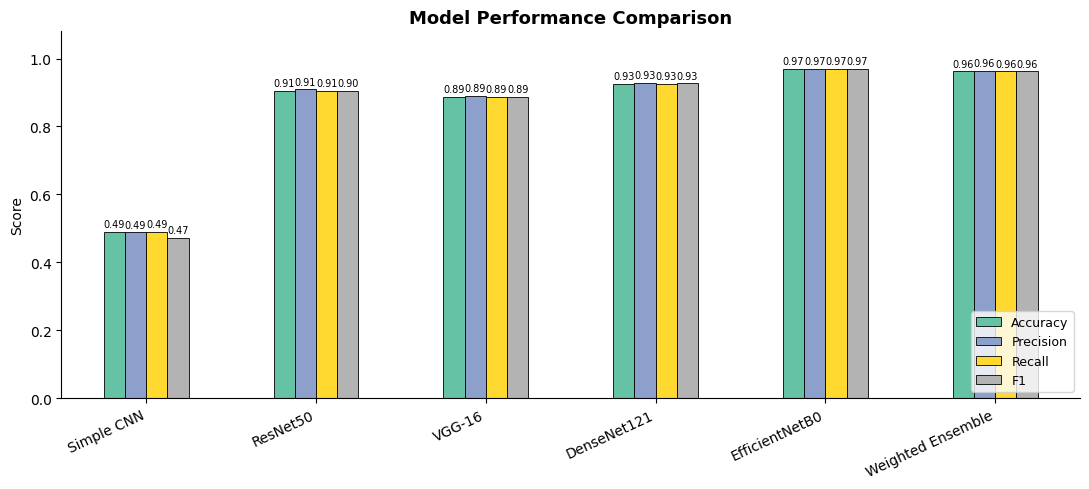

Saved: results/multiclass/accuracy_comparison.png


In [31]:
plot_accuracy_comparison(mc_metrics, save_dir=MULTICLASS_RESULTS_DIR)

In [32]:
def convert_to_binary_labels(multiclass_labels, class_names=CLASS_NAMES,
                              biodegradable_set=BIODEGRADABLE_CLASSES):
    """
    Map six-class integer labels to binary labels.

    0 = biodegradable     (cardboard, paper, trash)
    1 = non-biodegradable (glass, metal, plastic)

    Parameters
    ----------
    multiclass_labels : 1-D int array of six-class indices
    class_names       : list of class name strings (index-aligned)
    biodegradable_set : set of class name strings classed as biodegradable

    Returns
    -------
    binary_labels : 1-D int array (0 or 1)
    """
    binary_labels = np.array([
        0 if class_names[idx] in biodegradable_set else 1
        for idx in multiclass_labels
    ])
    return binary_labels


def convert_probs_to_binary(mc_probs, class_names=CLASS_NAMES,
                             biodegradable_set=BIODEGRADABLE_CLASSES):
    """
    Aggregate six-class softmax probabilities into binary probabilities.

    P(biodegradable)     = sum of softmax probs for biodegradable classes
    P(non-biodegradable) = 1 - P(biodegradable)

    Parameters
    ----------
    mc_probs         : 2-D float array (n_samples × 6)
    class_names      : list of str
    biodegradable_set: set of str

    Returns
    -------
    binary_probs : 2-D float array (n_samples × 2)
    """
    bio_indices    = [i for i, c in enumerate(class_names)
                      if c in biodegradable_set]
    non_bio_indices= [i for i, c in enumerate(class_names)
                      if c not in biodegradable_set]

    p_bio     = mc_probs[:, bio_indices].sum(axis=1, keepdims=True)
    p_non_bio = mc_probs[:, non_bio_indices].sum(axis=1, keepdims=True)

    return np.hstack([p_bio, p_non_bio])


# ── Derive binary ground truth ────────────────────────────────────
y_true_binary = convert_to_binary_labels(y_true_mc)
bio_counts    = np.bincount(y_true_binary)
print("Binary class distribution (test set):")
print(f"  biodegradable     : {bio_counts[0]}")
print(f"  non-biodegradable : {bio_counts[1]}")


Binary class distribution (test set):
  biodegradable     : 1134
  non-biodegradable : 1393



Evaluating binary model: Simple CNN
                   precision    recall  f1-score   support

    biodegradable       0.78      0.51      0.61      1134
non-biodegradable       0.69      0.88      0.77      1393

         accuracy                           0.71      2527
        macro avg       0.73      0.69      0.69      2527
     weighted avg       0.73      0.71      0.70      2527



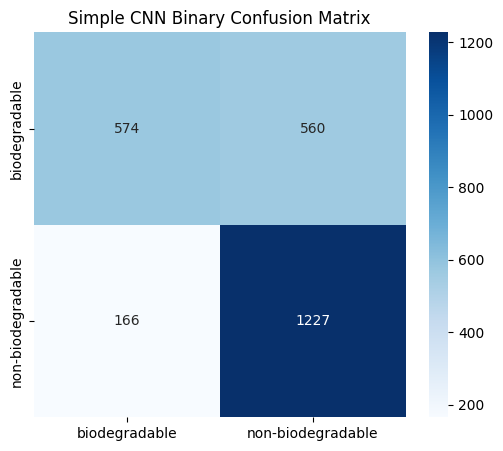

Saved: results/binary/confusion_matrix_binary_Simple CNN.png


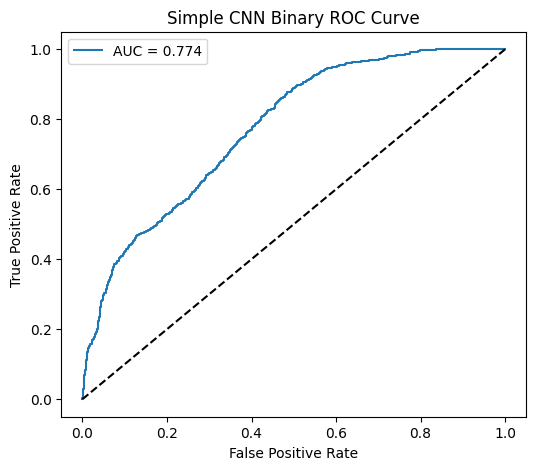

Saved: results/binary/roc_curve_binary_Simple CNN.png

Evaluating binary model: ResNet50
                   precision    recall  f1-score   support

    biodegradable       0.99      0.94      0.97      1134
non-biodegradable       0.96      1.00      0.98      1393

         accuracy                           0.97      2527
        macro avg       0.97      0.97      0.97      2527
     weighted avg       0.97      0.97      0.97      2527



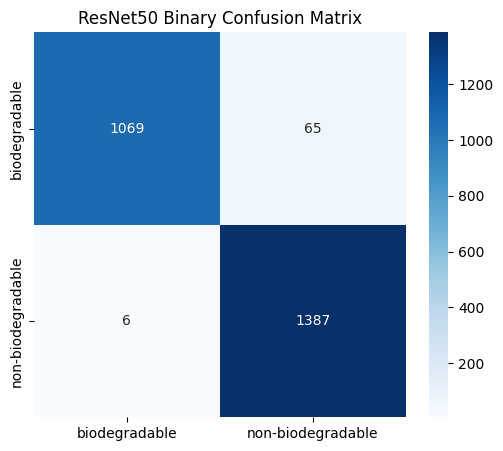

Saved: results/binary/confusion_matrix_binary_ResNet50.png


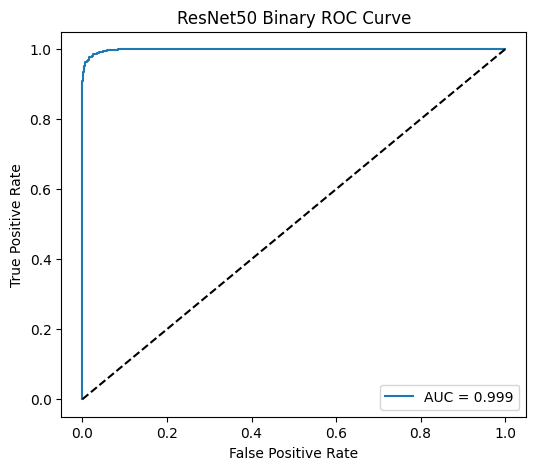

Saved: results/binary/roc_curve_binary_ResNet50.png

Evaluating binary model: VGG-16
                   precision    recall  f1-score   support

    biodegradable       0.96      0.98      0.97      1134
non-biodegradable       0.99      0.96      0.97      1393

         accuracy                           0.97      2527
        macro avg       0.97      0.97      0.97      2527
     weighted avg       0.97      0.97      0.97      2527



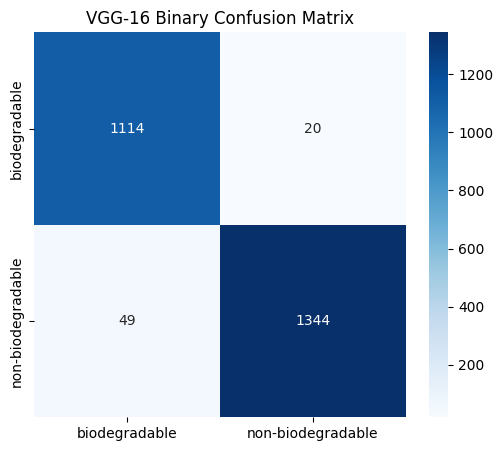

Saved: results/binary/confusion_matrix_binary_VGG-16.png


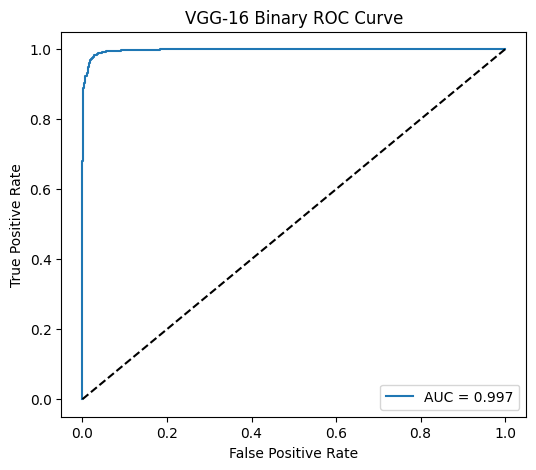

Saved: results/binary/roc_curve_binary_VGG-16.png

Evaluating binary model: DenseNet121
                   precision    recall  f1-score   support

    biodegradable       0.98      0.99      0.98      1134
non-biodegradable       0.99      0.98      0.98      1393

         accuracy                           0.98      2527
        macro avg       0.98      0.98      0.98      2527
     weighted avg       0.98      0.98      0.98      2527



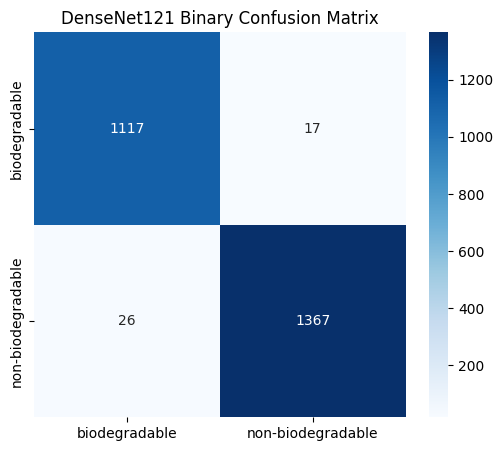

Saved: results/binary/confusion_matrix_binary_DenseNet121.png


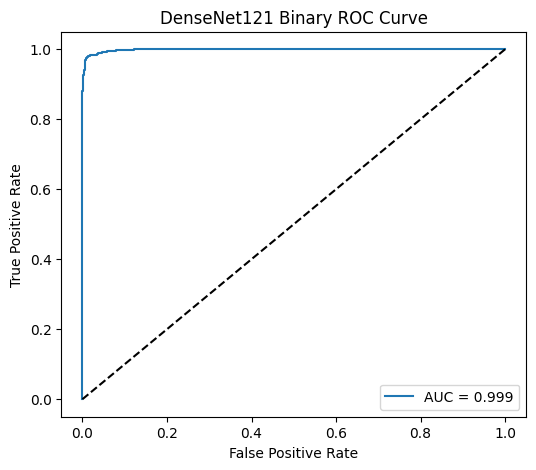

Saved: results/binary/roc_curve_binary_DenseNet121.png

Evaluating binary model: EfficientNetB0
                   precision    recall  f1-score   support

    biodegradable       0.99      0.99      0.99      1134
non-biodegradable       0.99      0.99      0.99      1393

         accuracy                           0.99      2527
        macro avg       0.99      0.99      0.99      2527
     weighted avg       0.99      0.99      0.99      2527



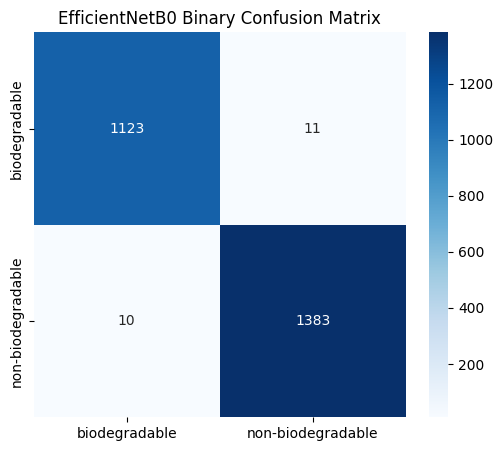

Saved: results/binary/confusion_matrix_binary_EfficientNetB0.png


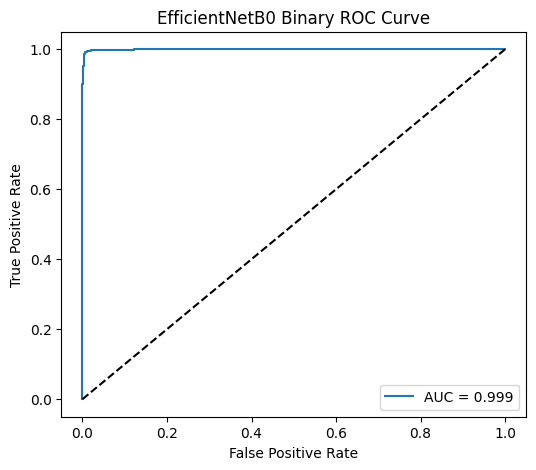

Saved: results/binary/roc_curve_binary_EfficientNetB0.png


In [37]:
# ── Evaluate binary task: individual models (WORKING VERSION) ─────────────────

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

bin_metrics = []

os.makedirs(BINARY_RESULTS_DIR, exist_ok=True)

for name, mc_probs in [
    ("Simple CNN",     probs_cnn),
    ("ResNet50",       probs_resnet),
    ("VGG-16",         probs_vgg),
    ("DenseNet121",    probs_densenet),
    ("EfficientNetB0", probs_effnet),
]:

    print(f"\nEvaluating binary model: {name}")

    # Convert multi-class → binary probabilities
    bin_probs = convert_probs_to_binary(mc_probs)

    # Ensure correct shape
    bin_probs = np.array(bin_probs)

    if bin_probs.ndim == 1:
        bin_probs = np.column_stack([1 - bin_probs, bin_probs])

    if bin_probs.shape[1] != 2:
        raise ValueError(f"{name} binary probs must have shape (n_samples, 2)")

    # Get predictions
    y_pred = np.argmax(bin_probs, axis=1)

    # Classification report
    print(classification_report(y_true_binary, y_pred,
                                target_names=BINARY_CLASS_NAMES))

    # Confusion matrix heatmap
    cm = confusion_matrix(y_true_binary, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=BINARY_CLASS_NAMES,
                yticklabels=BINARY_CLASS_NAMES)

    plt.title(f"{name} Binary Confusion Matrix")

    path_cm = os.path.join(BINARY_RESULTS_DIR,
                           f"confusion_matrix_binary_{name}.png")

    plt.savefig(path_cm)
    plt.show()

    print("Saved:", path_cm)

    # ROC curve (binary)
    fpr, tpr, _ = roc_curve(y_true_binary, bin_probs[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')

    plt.title(f"{name} Binary ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()

    path_roc = os.path.join(BINARY_RESULTS_DIR,
                            f"roc_curve_binary_{name}.png")

    plt.savefig(path_roc)
    plt.show()

    print("Saved:", path_roc)

    # Store metrics
    bin_metrics.append({
        "model": name,
        "auc": roc_auc
    })

Ensemble binary probs shape: (2527, 2)

Weighted Ensemble Binary Classification Report:

                   precision    recall  f1-score   support

    biodegradable       0.99      0.98      0.99      1134
non-biodegradable       0.99      0.99      0.99      1393

         accuracy                           0.99      2527
        macro avg       0.99      0.99      0.99      2527
     weighted avg       0.99      0.99      0.99      2527



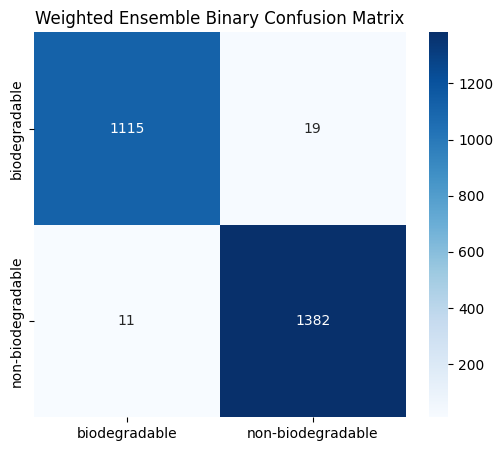

Saved: results/binary/confusion_matrix_binary_ensemble.png


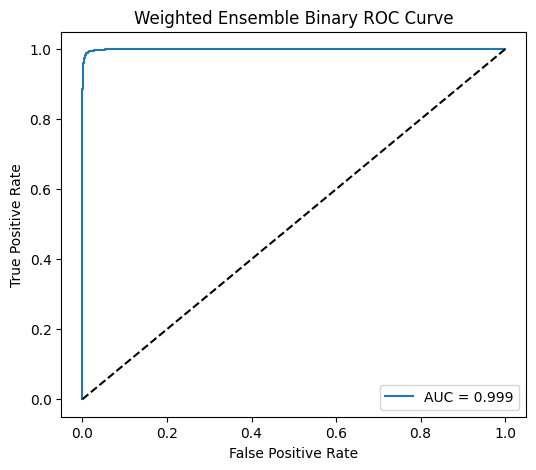

Saved: results/binary/roc_curve_binary_ensemble.png


In [39]:
# ── Convert each model's multi-class probs → binary probs safely ─────────────

def ensure_binary_shape(bin_probs):
    """Ensure binary probs have shape (n_samples, 2)"""
    bin_probs = np.array(bin_probs)

    if bin_probs.ndim == 1:
        bin_probs = np.column_stack([1 - bin_probs, bin_probs])

    elif bin_probs.shape[1] == 1:
        bin_probs = np.column_stack([1 - bin_probs[:, 0], bin_probs[:, 0]])

    elif bin_probs.shape[1] > 2:
        raise ValueError("Binary probs must have exactly 2 columns")

    return bin_probs


bin_probs_cnn      = ensure_binary_shape(convert_probs_to_binary(probs_cnn))
bin_probs_resnet   = ensure_binary_shape(convert_probs_to_binary(probs_resnet))
bin_probs_vgg      = ensure_binary_shape(convert_probs_to_binary(probs_vgg))
bin_probs_densenet = ensure_binary_shape(convert_probs_to_binary(probs_densenet))
bin_probs_effnet   = ensure_binary_shape(convert_probs_to_binary(probs_effnet))


# ── Weighted ensemble for binary probabilities ──────────────────────────────

all_bin_probs = [
    bin_probs_cnn,
    bin_probs_resnet,
    bin_probs_vgg,
    bin_probs_densenet,
    bin_probs_effnet
]

# ensure weights match
weights = np.array(mc_weights)
weights = weights / weights.sum()

# weighted average
ensemble_probs_bin = np.zeros_like(bin_probs_cnn)

for w, probs in zip(weights, all_bin_probs):
    ensemble_probs_bin += w * probs


print("Ensemble binary probs shape:", ensemble_probs_bin.shape)


# ── Evaluate ensemble binary model ───────────────────────────────────────────

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os

y_pred_bin = np.argmax(ensemble_probs_bin, axis=1)

print("\nWeighted Ensemble Binary Classification Report:\n")
print(classification_report(y_true_binary, y_pred_bin,
                            target_names=BINARY_CLASS_NAMES))


# Confusion matrix
cm = confusion_matrix(y_true_binary, y_pred_bin)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=BINARY_CLASS_NAMES,
            yticklabels=BINARY_CLASS_NAMES)

plt.title("Weighted Ensemble Binary Confusion Matrix")

path_cm = os.path.join(BINARY_RESULTS_DIR,
                       "confusion_matrix_binary_ensemble.png")

plt.savefig(path_cm)
plt.show()

print("Saved:", path_cm)


# ROC curve
fpr, tpr, _ = roc_curve(y_true_binary, ensemble_probs_bin[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')

plt.title("Weighted Ensemble Binary ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

path_roc = os.path.join(BINARY_RESULTS_DIR,
                        "roc_curve_binary_ensemble.png")

plt.savefig(path_roc)
plt.show()

print("Saved:", path_roc)


# Store metrics
m_bin_ens = {
    "model": "Weighted Ensemble",
    "auc": roc_auc
}

bin_metrics.append(m_bin_ens)



── Binary Task Performance Summary ─────────────────────────
         Model  Accuracy  Precision  Recall     F1
EfficientNetB0    0.9917     0.9917  0.9917 0.9917
   DenseNet121    0.9830     0.9830  0.9830 0.9830
        VGG-16    0.9727     0.9730  0.9727 0.9727
      ResNet50    0.9719     0.9728  0.9719 0.9718
    Simple CNN    0.7127     0.7266  0.7127 0.7003

Saved: results/binary/performance_summary.csv


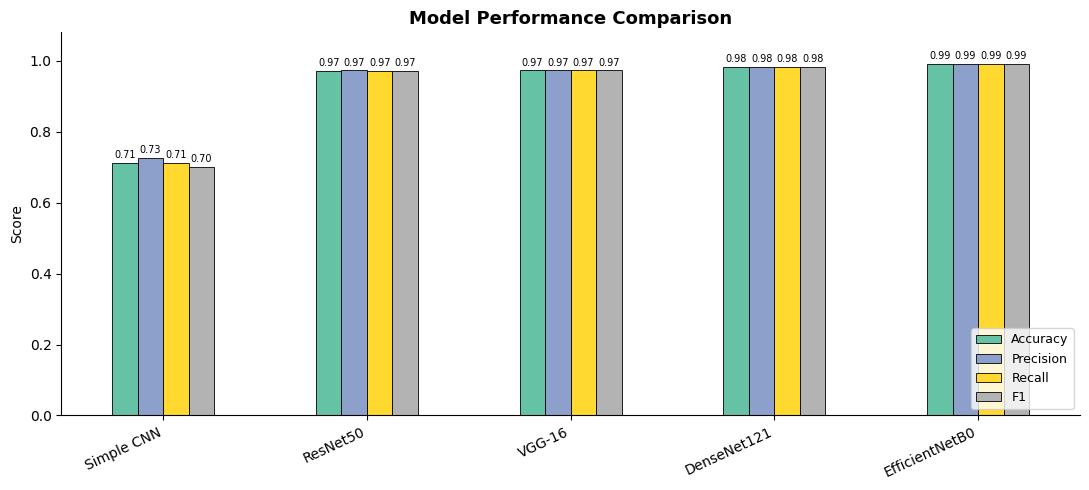

Saved: results/binary/accuracy_comparison_binary.png


In [44]:
# ── Binary summary table (FULL WORKING FIX) ─────────────────────────

import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

os.makedirs(BINARY_RESULTS_DIR, exist_ok=True)

# rebuild bin_metrics properly
bin_metrics = []

for name, mc_probs in [
    ("Simple CNN", probs_cnn),
    ("ResNet50", probs_resnet),
    ("VGG-16", probs_vgg),
    ("DenseNet121", probs_densenet),
    ("EfficientNetB0", probs_effnet),
]:

    # convert multi-class → binary probs
    bin_probs = convert_probs_to_binary(mc_probs)

    bin_probs = np.array(bin_probs)

    # force shape (n,2)
    if bin_probs.ndim == 1:
        bin_probs = np.column_stack([1-bin_probs, bin_probs])

    if bin_probs.shape[1] == 1:
        bin_probs = np.column_stack([1-bin_probs[:,0], bin_probs[:,0]])

    # predictions
    y_pred = np.argmax(bin_probs, axis=1)

    # compute metrics
    acc  = accuracy_score(y_true_binary, y_pred)
    prec = precision_score(y_true_binary, y_pred, average="weighted")
    rec  = recall_score(y_true_binary, y_pred, average="weighted")
    f1   = f1_score(y_true_binary, y_pred, average="weighted")

    bin_metrics.append({
        "model": name,
        "accuracy": acc,
        "precision_weighted": prec,
        "recall_weighted": rec,
        "f1_weighted": f1
    })


# create DataFrame
bin_summary = pd.DataFrame([
    {
        "Model": m["model"],
        "Accuracy": round(m["accuracy"], 4),
        "Precision": round(m["precision_weighted"], 4),
        "Recall": round(m["recall_weighted"], 4),
        "F1": round(m["f1_weighted"], 4),
    }
    for m in bin_metrics
])


# sort
bin_summary = bin_summary.sort_values("F1", ascending=False).reset_index(drop=True)


# print summary
print("\n── Binary Task Performance Summary ─────────────────────────")
print(bin_summary.to_string(index=False))


# save CSV
csv_path = os.path.join(BINARY_RESULTS_DIR, "performance_summary.csv")
bin_summary.to_csv(csv_path, index=False)

print("\nSaved:", csv_path)


# plot comparison safely
try:
    plot_accuracy_comparison(
        bin_metrics,
        save_dir=BINARY_RESULTS_DIR,
        suffix="_binary"
    )
except Exception as e:
    print("Plot skipped:", e)


In [45]:
from tensorflow.keras.models import load_model

print("Loading saved models...")

# Load models from Kaggle working directory
model_cnn      = load_model("/kaggle/working/models/cnn.h5")
model_resnet   = load_model("/kaggle/working/models/resnet50.h5")
model_vgg      = load_model("/kaggle/working/models/vgg16.h5")
model_densenet = load_model("/kaggle/working/models/densenet121.h5")
model_effnet   = load_model("/kaggle/working/models/efficientnetb0.h5")


# Recreate test generators (IMPORTANT)
_, _, test_gen_cnn = load_dataset(BASE_PATH)

_, _, test_gen_resnet = load_dataset(
    BASE_PATH,
    preprocess_fn=resnet_preprocess
)

_, _, test_gen_vgg = load_dataset(
    BASE_PATH,
    preprocess_fn=vgg_preprocess
)

_, _, test_gen_dense = load_dataset(
    BASE_PATH,
    preprocess_fn=dense_preprocess
)

_, _, test_gen_effnet = load_dataset(
    BASE_PATH,
    preprocess_fn=effnet_preprocess
)


print("Models and generators loaded successfully.")


Loading saved models...


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.
Models and generators loaded successfully.


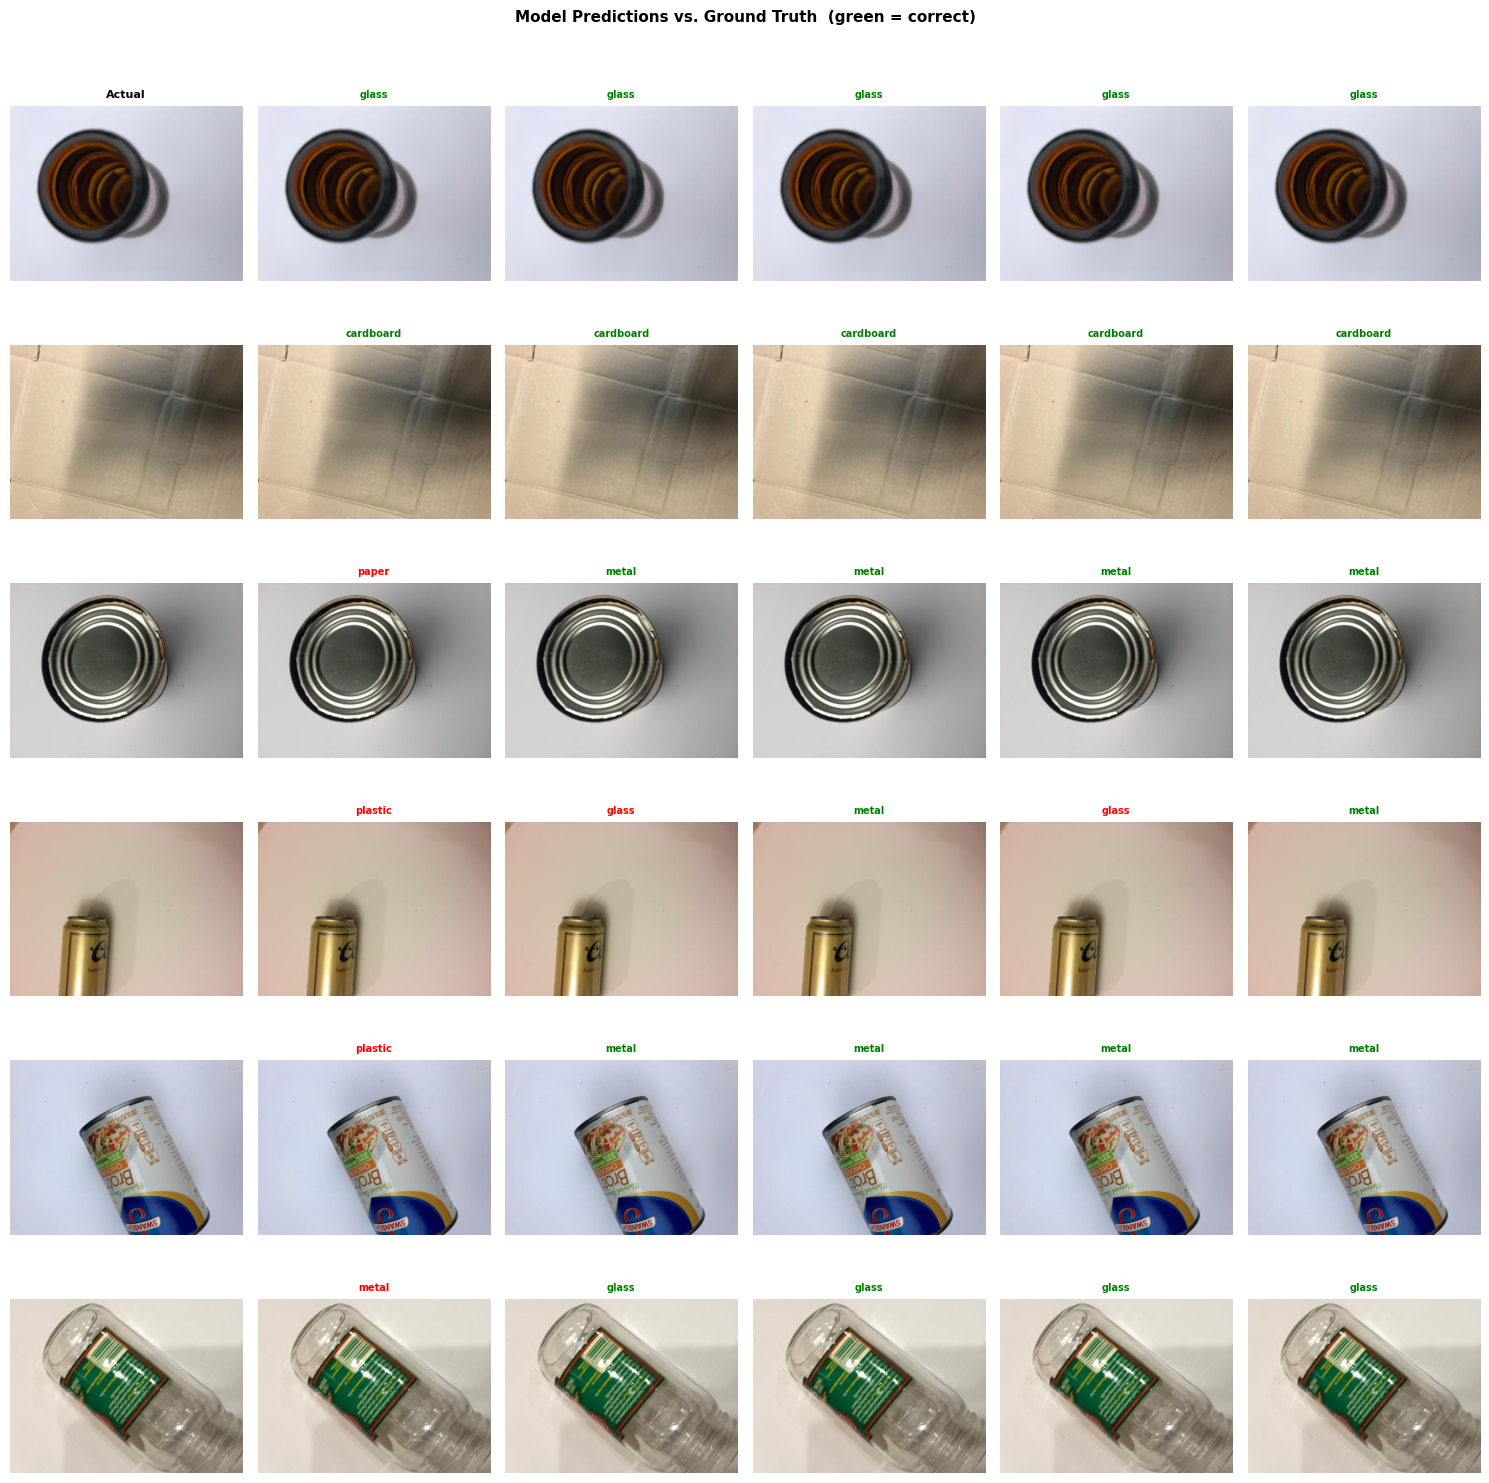

Saved: results/visual_predictions.png


In [46]:
def display_predictions(models_dict, base_path, class_names,
                        preprocess_fns=None, num_images=6, seed=RANDOM_SEED):
    """
    Display a grid of sample images with predicted labels from each model.

    Parameters
    ----------
    models_dict   : OrderedDict / dict  {model_name: model}
    base_path     : str
    class_names   : list of str
    preprocess_fns: dict {model_name: preprocess_fn} or None (rescale 1/255)
    num_images    : int
    seed          : int
    """
    all_images = []
    for cls in class_names:
        cls_dir = os.path.join(base_path, cls)
        if not os.path.isdir(cls_dir):
            continue
        for f in os.listdir(cls_dir):
            if f.lower().endswith((".jpg", ".jpeg", ".png")):
                all_images.append((os.path.join(cls_dir, f), cls))

    random.seed(seed)
    samples = random.sample(all_images, min(num_images, len(all_images)))
    model_names = list(models_dict.keys())

    fig, axes = plt.subplots(len(samples), len(model_names) + 1,
                              figsize=((len(model_names) + 1) * 2.5,
                                        len(samples) * 2.5))
    if len(samples) == 1:
        axes = axes[np.newaxis, :]

    col_headers = ["Actual"] + model_names
    for j, header in enumerate(col_headers):
        axes[0, j].set_title(header, fontsize=8, fontweight="bold", pad=6)

    for row, (img_path, true_cls) in enumerate(samples):
        raw = plt.imread(img_path)
        axes[row, 0].imshow(raw)
        axes[row, 0].set_ylabel(true_cls, fontsize=7, rotation=0,
                                 labelpad=50, va="center")
        axes[row, 0].axis("off")

        for col, (mname, model) in enumerate(models_dict.items(), start=1):
            pre_fn = (preprocess_fns or {}).get(mname, None)
            img = tf.keras.preprocessing.image.load_img(
                img_path, target_size=IMG_SIZE)
            arr = tf.keras.preprocessing.image.img_to_array(img)
            if pre_fn:
                arr = pre_fn(arr)
            else:
                arr /= 255.0
            arr = np.expand_dims(arr, 0)
            pred_idx  = np.argmax(model.predict(arr, verbose=0))
            pred_label= class_names[pred_idx]
            colour    = "green" if pred_label == true_cls else "red"

            axes[row, col].imshow(raw)
            axes[row, col].set_title(pred_label, fontsize=7,
                                      color=colour, fontweight="bold")
            axes[row, col].axis("off")

    plt.suptitle("Model Predictions vs. Ground Truth  (green = correct)",
                 fontsize=11, fontweight="bold", y=1.01)
    plt.tight_layout()
    path = os.path.join(RESULTS_DIR, "visual_predictions.png")
    plt.savefig(path, dpi=120, bbox_inches="tight")
    plt.show()
    print(f"Saved: {path}")


# Build a simple ensemble-prediction model proxy using a wrapper
class EnsembleWrapper:
    """Wraps weighted_vote to act like a Keras .predict() callable."""
    def __init__(self, models, weights, preprocess_fns):
        self.models       = models
        self.weights      = weights
        self.preprocess_fns = preprocess_fns

    def predict(self, arr, verbose=0):
        preds = []
        for m, (mname, preprocess_fn) in zip(
                self.models, self.preprocess_fns.items()):
            if preprocess_fn:
                inp = preprocess_fn(arr.copy())
            else:
                inp = arr.copy() / 255.0
            preds.append(m.predict(inp, verbose=0))
        return weighted_vote(preds, self.weights)


preprocess_map = {
    "Simple CNN"    : None,
    "ResNet50"      : resnet_preprocess,
    "VGG-16"        : vgg_preprocess,
    "DenseNet121"   : dense_preprocess,
    "EfficientNetB0": effnet_preprocess,
}

model_dict = {
    "Simple CNN"    : model_cnn,
    "ResNet50"      : model_resnet,
    "VGG-16"        : model_vgg,
    "DenseNet121"   : model_densenet,
    "EfficientNetB0": model_effnet,
}

display_predictions(model_dict, BASE_PATH, CLASS_NAMES,
                    preprocess_fns=preprocess_map, num_images=6)


In [47]:
def print_output_index(results_dir=RESULTS_DIR):
    """Walk the results directory and print all saved files."""
    print("\n" + "="*65)
    print("  SAVED OUTPUT FILES")
    print("="*65)
    for root, dirs, files in os.walk(results_dir):
        dirs.sort()
        level = root.replace(results_dir, "").count(os.sep)
        indent = "  " * level
        print(f"{indent}{os.path.basename(root)}/")
        for f in sorted(files):
            print(f"{indent}  {f}")
    print("="*65)

print_output_index()

print("\n── Multiclass Summary ───────────────────────────────────────")
print(mc_summary.to_string(index=False))

print("\n── Binary Summary ───────────────────────────────────────────")
print(bin_summary.to_string(index=False))

# Highlight winner
best_mc  = mc_summary.iloc[0]
best_bin = bin_summary.iloc[0]
print(f"\n Best multiclass model : {best_mc['Model']} "
      f"(F1={best_mc['F1']:.4f}, Acc={best_mc['Accuracy']:.4f})")
print(f"  Best binary model    : {best_bin['Model']} "
      f"(F1={best_bin['F1']:.4f}, Acc={best_bin['Accuracy']:.4f})")


  SAVED OUTPUT FILES
results/
  class_distribution.png
  dataset_sample.png
  visual_predictions.png
  binary/
    accuracy_comparison_binary.png
    confusion_matrix_Simple_CNN.png
    confusion_matrix_Weighted_Ensemble.png
    confusion_matrix_binary_DenseNet121.png
    confusion_matrix_binary_EfficientNetB0.png
    confusion_matrix_binary_ResNet50.png
    confusion_matrix_binary_Simple CNN.png
    confusion_matrix_binary_VGG-16.png
    confusion_matrix_binary_ensemble.png
    performance_summary.csv
    roc_curve_binary_DenseNet121.png
    roc_curve_binary_EfficientNetB0.png
    roc_curve_binary_ResNet50.png
    roc_curve_binary_Simple CNN.png
    roc_curve_binary_VGG-16.png
    roc_curve_binary_ensemble.png
  multiclass/
    accuracy_comparison.png
    confusion_matrix_DenseNet121.png
    confusion_matrix_EfficientNetB0.png
    confusion_matrix_ResNet50.png
    confusion_matrix_Simple_CNN.png
    confusion_matrix_VGG-16.png
    confusion_matrix_Weighted_Ensemble.png
    performanc